In [2]:
### Install and Import

!pip install ta

## Python Libraries
import os
import pickle
from tqdm import trange
from tqdm import tqdm

## Standard Scientific Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import pandas as pd
import ta

## Pytorch Utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
random_seed=4
np.random.seed(random_seed)

## Mount Colab
from google.colab import drive 
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=d3f3607824731d1065130218db0bb9289703ec168478d60cd9670a39eddaf0f3
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
Mounted at /content/drive
cuda


In [3]:
### Define Useful Fn

def zero_mean_SVD_trunc(X, min_s, max_k=100):
# can choose to truncate by either minimum singular value or max number of singular values

  n = X.shape[0]
  Xzm = np.matmul(np.eye(n) - (1/n)*np.ones((n,n)), X)
  U, Sigma, Vt = np.linalg.svd(Xzm, full_matrices=False)

  k = 0
  for i in range(1, len(Sigma)):
    if k == max_k or Sigma[i] < min_s:
      break
    k+=1

  # Uk = U[:, :(k+1)]
  # Uk_p = np.append(Uk, (1/np.sqrt(n)) * np.ones((n,1)), axis=1) # training on U basis vectors

  Vk = Vt[:(k+1), :].T
  Xzm_Vk = np.matmul(Xzm, Vk)
  Xzm_Vk_p = np.append(Xzm_Vk, (1/np.sqrt(n)) * np.ones((n,1)), axis=1) # training on U^T \Sigma

  return Xzm_Vk_p, Vk

def MSE_(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [4]:
### Import Stock Data

data_source = "RH"

## Historical Data (for training the bot on in-house)
cleaned_dfs_c = np.load("/content/drive/My Drive/ECE271B/Project/data_df_full_" + data_source + ".npy", allow_pickle=True)
cleaned_dfs = cleaned_dfs_c.item()

# ## Import Predictions (for simulating with premade predictions)
# preds = {}
# for cvxty in ["NonConvex", "Convex"]:
#   preds[cvxty] = {}
#   for tick in ["AAPL", "MSFT", "IBM", "ARCO", "PG"]:
#     test = np.load("/content/drive/My Drive/ECE271B/Project/modelsFinal/" + cvxty + "/RH/AllTAs/" + tick + "/test_preds.npy", allow_pickle=True)
#     test_labels = np.load("/content/drive/My Drive/ECE271B/Project/modelsFinal/" + cvxty + "/RH/AllTAs/" + tick + "/test_labels.npy", allow_pickle=True)
#     preds[cvxty][tick] = np.load("/content/drive/My Drive/ECE271B/Project/modelsFinal/" + cvxty + "/RH/AllTAs/" + tick + "/test_preds.npy", allow_pickle=True).item()

,begins_at,open_price,close_price,high_price,low_price,volume,volume_adi_n,volume_obv_n,volume_cmf_n,volume_fi_n,...,momentum_ppo_signal_n,momentum_ppo_hist_n,momentum_pvo_n,momentum_pvo_signal_n,momentum_pvo_hist_n,momentum_kama_n,others_dr_n,others_dlr_n,others_cr_n,perc_change_1hr
0,2021-12-06T20:00:00Z,165.5400,165.2900,165.8300,164.9900,5922992.0,-2.340433,-1.319388,-0.543153,0.544320,...,0.169731,0.647753,-1.398675,-0.846280,-1.367429,-1.448315,-0.206623,-0.203923,-1.335741,2.709374
1,2021-12-07T15:00:00Z,170.1500,170.7450,171.2800,169.9750,9312276.0,-2.293605,-1.132932,-0.338637,2.503364,...,0.277646,1.293682,-0.706998,-0.847374,-0.037329,-1.237069,4.329547,4.280483,-0.306296,0.345555
2,2021-12-07T16:00:00Z,170.7400,171.0666,171.4773,170.4900,6217399.0,-2.264431,-1.008444,0.100010,2.210282,...,0.417393,1.661744,-0.658119,-0.836202,0.039137,-0.934202,0.246564,0.251018,-0.245605,0.193545
3,2021-12-07T17:00:00Z,171.0711,171.1050,171.5800,170.8150,4534411.0,-2.295052,-0.917653,-0.009668,1.885294,...,0.568694,1.795345,-0.884409,-0.883042,-0.322471,-0.720554,0.028890,0.032697,-0.238359,0.016891
4,2021-12-07T18:00:00Z,171.1000,170.4400,171.1400,170.3210,3745331.0,-2.369247,-0.992644,-0.410688,1.499034,...,0.709887,1.678456,-1.198624,-0.997963,-0.746850,-0.636553,-0.510491,-0.509851,-0.363855,-0.387233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,2022-02-22T15:00:00Z,165.7200,164.6600,166.6801,164.5703,4881480.0,1.006948,-1.852796,-0.900580,-1.001558,...,-0.701069,-0.841159,1.083648,0.366717,1.509724,-0.966912,-2.302132,-2.328219,-1.454632,-0.643751
314,2022-02-22T16:00:00Z,164.6600,164.6950,165.3200,164.4200,4158846.0,0.961784,-1.769525,-1.302856,-0.868866,...,-0.787431,-0.952723,1.008961,0.545985,1.086927,-1.060363,0.027327,0.031128,-1.448027,0.012145
315,2022-02-22T17:00:00Z,164.6800,164.0950,165.0450,163.9000,2956880.0,0.907338,-1.828729,-1.574980,-0.832716,...,-0.880778,-1.033495,0.642718,0.599124,0.300733,-1.154413,-0.478555,-0.477665,-1.561256,-0.341214
316,2022-02-22T18:00:00Z,164.1200,162.9350,164.3500,162.7300,3393498.0,0.836558,-1.896676,-1.831391,-0.889124,...,-0.985356,-1.163363,0.456317,0.595691,-0.051908,-1.280426,-0.928061,-0.931412,-1.780166,-0.730375


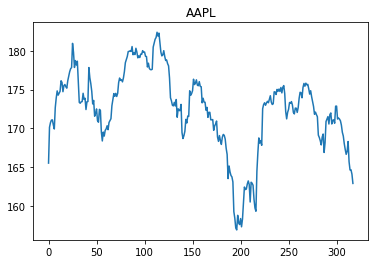

In [5]:
## eg. AAPL 
plt.plot(cleaned_dfs["AAPL"].open_price)
plt.title("AAPL")
cleaned_dfs["AAPL"]

In [6]:
# ## OLD

# class ConvexStockNet(nn.Module):

#     def __init__(self, n_features, n_regions, n_outputs=1):
#         '''
#         Args:
#             n_features (int): The number of features per data point.
#             n_regions  (int): The number of data masks D_i to be created (see eq. 8).
#             n_outputs  (int): The number of outputs from the network.

#             NOTE: The number of hidden units in the resulting ReLU network
#                   is influenced by n_regions.
#                     n_units <= n_regions
#                   depending on the sparisty of the convex problem solution.
#         '''
#         super(ConvexStockNet, self).__init__()

#         # Network Information
#         self.device = torch.device(device)
#         self.n_features = n_features
#         self.n_regions = n_regions
#         self.n_outputs = n_outputs

#         # Convex Problem Variables (Don't move parameters to device, move model to device)
#         self.U = nn.Parameter(data=torch.zeros(self.n_features, self.n_regions), requires_grad=True)
#         self.V = nn.Parameter(data=torch.zeros(self.n_features, self.n_regions), requires_grad=True)

#         # Create random sample of sign patterns (keep consistent for all batches)
#         self.S = torch.randn(self.n_features, self.n_regions).to(device)

#         return

#     def forward(self, x):

#         # worreid the translation doesn't work
#         # x = x @ self.W1
#         # x = F.relu(x)
#         # x = x @ self.W2

#         Dmat = torch.sign(F.relu(x @ self.S))
#         Xu, Xv = torch.matmul(x, self.U), torch.matmul(x, self.V)
#         DXu, DXv = torch.mul(Dmat, Xu), torch.mul(Dmat, Xv)
#         x = DXu.sum(axis=1) - DXv.sum(axis=1)

#         return x

#     def train(self, train_set, test_set, n_epochs, lr=1e-20, lamb=1e-2, rho=1e-2):
#         '''
#         Args:
#             train_set (DataLoader): The dataset to be used for training.
#             test_set  (DataLoader): The dataset to be used for validation.
#             n_epochs         (int): The number iterations through each batch.
#             lr             (float): Learning rate of SGD optimizer.
#             lamb           (float): Lagrange multiplier for l2l1-norm term. 1e-2
#             rho            (float): Lagrange multiplier for constraints.
#         '''
#         n_examples = train_set.batch_size

#         residual_loss = torch.nn.MSELoss(reduction='sum')
#         # residual_loss = torch.nn.MSELoss(reduction='sum')
#         test_loss_fn=nn.MSELoss()  
        
#         optimizer = torch.optim.SGD(self.parameters(), lr=lr)

#         train_loss = []

#         train_loss_per_epoch=[] # added this to just look at visulation
#         test_loss_per_epoch=[]   # non convex test
#         non_conv_train_loss_per_epoch=[] # non conv  
#         non_conv_train_loss_per_epoch2=[] #slop  

#         test_residual_loss=[]

#         progress_bar = trange(n_epochs)
#         for t in progress_bar:
#             epoch_train_loss=0 # added this for visualization temporarily
#             non_conv_epoch_train_loss=0
#             for i, batch in enumerate(train_set):
#                 batch = batch.to(self.device).float()
#                 data, labels = batch[:, :-1], batch[:, -1]

#                 Dmat = torch.sign(F.relu(data @ self.S))

#                 Xu = torch.matmul(data, self.U)
#                 Xv = torch.matmul(data, self.V)
                
#                 DXu = torch.mul(Dmat, Xu)
#                 DXv = torch.mul(Dmat, Xv)

#                 # Term 1: Residual L2 Error
#                 residual_error = residual_loss(DXu.sum(axis=1) - DXv.sum(axis=1), labels)
#                 non_conv_epoch_train_loss+=residual_error.cpu().detach().item()

#                 # Term 2: Mixed-Norm Error
#                 norm_U = torch.linalg.norm(self.U, axis=0).sum()
#                 norm_V = torch.linalg.norm(self.V, axis=0).sum()

#                 # Term 3: Constraints
#                 # NOTE: Pilanci's code has a max() in there, not sure why.
#                 # NOTE: Also, I can use sum here rather than inner product assuming
#                 #       that all the rho's are the same.
#                 constraint = torch.sum(F.relu(-2*DXu + Xu)) + torch.sum(F.relu(-2*DXv + Xv))

#                 # Total Loss
#                 total_loss = residual_error + lamb * (norm_U + norm_V) + rho * constraint
#                 t_loss = total_loss.cpu().detach().item()
#                 epoch_train_loss+=t_loss; # added this for visualization temporarily
#                 train_loss.append(t_loss)
#                 progress_bar.set_description(f'{t_loss:.4f}')

#                 # Back propagation w/ SGD to update network weights.
#                 optimizer.zero_grad()
#                 total_loss.backward()
#                 optimizer.step()
#             train_loss_per_epoch.append(epoch_train_loss/ len(train_set)) # just changed this for visualization temporarily
#             non_conv_train_loss_per_epoch.append(non_conv_epoch_train_loss/ len(train_set))

#             self.W2 = torch.linalg.norm(self.U, axis=0)
#             self.W1 = self.U / self.W2

#             non_conv_epoch_train_loss2=0
#             for i, batch in enumerate(train_set):
#                 batch = batch.to(self.device).float()
#                 data, labels = batch[:, :-1], batch[:, -1]
#                 preds=self.forward(data)
#                 non_conv_epoch_train_loss2+=test_loss_fn(preds, labels).cpu().detach().item()

#             non_conv_train_loss_per_epoch2.append(non_conv_epoch_train_loss2/ len(train_set))

#             epoch_test_loss=0
#             res_test_loss=0
#             for i, batch in enumerate(test_set):
#                 batch = batch.to(self.device).float()
#                 data, labels = batch[:, :-1], batch[:, -1]
#                 preds=self.forward(data)
#                 epoch_test_loss+=test_loss_fn(preds, labels).cpu().detach().item()

#                 Dmat = torch.sign(F.relu(data @ self.S))
#                 Xu = torch.matmul(data, self.U)
#                 Xv = torch.matmul(data, self.V)
#                 DXu = torch.mul(Dmat, Xu)
#                 DXv = torch.mul(Dmat, Xv)

#                 # Term 1: Residual L2 Error
#                 residual_error = residual_loss(DXu.sum(axis=1) - DXv.sum(axis=1), labels)
#                 res_test_loss+=residual_error.cpu().detach().item()

#             test_residual_loss.append(res_test_loss/len(test_set))

#             test_loss_per_epoch.append(epoch_test_loss/ len(test_set))

#         # return np.asarray(train_loss)

#         self.W2 = torch.linalg.norm(self.U, axis=0)
#         self.W1 = self.U / self.W2

#         return (np.asarray(train_loss), np.asarray(train_loss_per_epoch), np.asarray(non_conv_train_loss_per_epoch),np.asarray(test_loss_per_epoch),np.asarray(non_conv_train_loss_per_epoch2), np.asarray(test_residual_loss),self.U)

In [7]:
### NEW

class ConvexStockNet(nn.Module):

    def __init__(self, n_features, n_regions, n_outputs=1):

        super(ConvexStockNet, self).__init__()

        self.params = {
            'n_features': n_features,
            'n_regions': n_regions,
            'n_outputs': n_outputs
        }

        self.U = nn.Parameter(data=torch.zeros(n_features, n_regions), requires_grad=True)
        self.V = nn.Parameter(data=torch.zeros(n_features, n_regions), requires_grad=True)
        self.S = nn.Parameter(data=torch.randn(n_features, n_regions), requires_grad=False)

        return

    def forward(self, x):
        # worried about the translation
        # self.W2 = torch.linalg.norm(self.U, axis=0)
        # self.W1 = self.U / self.W2
        # x = F.relu(x @ self.W1) @ self.W2

        # for x in x_it:
        #   x = x.to(self.U.device).float()

        x = x.to(self.U.device).float()

        Dmat = torch.sign(F.relu(x @ self.S))
        Xu, Xv = torch.matmul(x, self.U), torch.matmul(x, self.V)
        DXu, DXv = torch.mul(Dmat, Xu), torch.mul(Dmat, Xv)
        yh = DXu.sum(axis=1) - DXv.sum(axis=1)

        return yh

    def train(self, train_set, val_set, n_epochs, lr=1e-5, lamb=1e-2, rho=1e-2):

        l2_loss = nn.MSELoss(reduction='sum')
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        n_batch = len(train_set)

        train_loss = np.zeros([n_epochs, n_batch])
        val_loss = np.zeros([n_epochs, n_batch])
        progress_bar = tqdm(range(n_epochs))
        for t in progress_bar:
            for i, batch in enumerate(train_set):

                # Process data
                batch = batch.to(self.U.device).float()
                data, labels = batch[:, :-1], batch[:, -1]

                # Compute terms of convex problem.
                Dmat = torch.sign(F.relu(data @ self.S))

                Xu = torch.matmul(data, self.U)
                Xv = torch.matmul(data, self.V)
                DXu = torch.mul(Dmat, Xu)
                DXv = torch.mul(Dmat, Xv)

                # Xu = data @ self.U
                # Xv = data @ self.V
                # DXu = Dmat * Xu
                # DXv = Dmat * Xv

                l2_norm_error = l2_loss(DXu.sum(axis=1) - DXv.sum(axis=1), labels)
                mixed_norm_error = torch.linalg.norm(self.U, ord=2, dim=1).sum() + torch.linalg.norm(self.V, ord=2, dim=1).sum()
                constraint1 = F.relu(-2 * DXu + Xu)
                constraint2 = F.relu(-2 * DXu + Xu)
                constraint = torch.sum(constraint1) + torch.sum(constraint2)

                # Objective
                obj = l2_norm_error + lamb * mixed_norm_error + rho * constraint
                train_loss[t, i] = obj.cpu().detach().item()

                # Use SGD to optimize
                optimizer.zero_grad()
                obj.backward()
                optimizer.step()

                # # Test
                # for j, batch in enumerate(val_set):
                #     batch = batch.to(self.U.device).float()
                #     data, labels = batch[:, :-1], batch[:, -1]
                #     Dmat = torch.sign(F.relu(data @ self.S))

                #     Xu = torch.matmul(data, self.U)
                #     Xv = torch.matmul(data, self.V)
                #     DXu = torch.mul(Dmat, Xu)
                #     DXv = torch.mul(Dmat, Xv)

                #     # Xu = data @ self.U
                #     # Xv = data @ self.V
                #     # DXu = Dmat * Xu
                #     # DXv = Dmat * Xv

                #     l2_norm_error = l2_loss(DXu.sum(axis=1) - DXv.sum(axis=1), labels)
                #     mixed_norm_error = torch.norm(self.U, dim=1).sum() + torch.norm(self.V, dim=1).sum()

                #     constraint1 = F.relu(-2 * DXu + Xu)
                #     constraint2 = F.relu(-2 * DXu + Xu)

                #     # constraint1 = (-2 * DXu + Xu)
                #     # constraint2 = (-2 * DXu + Xu)

                #     constraint = torch.sum(constraint1) + torch.sum(constraint2)
                #     obj = l2_norm_error + lamb * mixed_norm_error + rho * constraint
                #     val_loss[t, i] += obj.cpu().detach().item()

                progress_bar.set_description(f'Loss = {train_loss[t, i]:.3f}')

        return train_loss, val_loss

In [8]:
class TwoLayerReLU(nn.Module):
    
    def __init__(self, dXin, dW1, dYpred=1):
        super(TwoLayerReLU, self).__init__()
        self.device = torch.device(device) # use gpu if availble
        self.net = nn.Sequential(
            nn.Linear(dXin, dW1, bias=False),
            nn.ReLU(),
            nn.Linear(dW1, dYpred, bias=False)
        ).to(self.device)
        
        self.net.apply(self.init_weights)
        return

    def init_weights(self, l):
        if isinstance(l, nn.Linear):
            nn.init.xavier_uniform_(l.weight)
            # l.bias.data.fill_(0.01)
        return

    def forward(self, x):
        x = x.to(self.device).float()
        x = self.net(x)
        return x

    def loss_with_reg(self, pred, y, beta=1e-2):
        '''
        Loss Function from Equation 2 in https://arxiv.org/pdf/2002.10553.pdf
        Code sourced from https://github.com/pilancilab/convex_nn/blob/e401184311dafbfa5ef9196941d3ddf003823fa4/convexnn_pytorch_stepsize_fig.py#L293
        '''
        loss = 0.5 * torch.norm(pred - y)**2
        
        ## l2 norm on first layer weights, l1 squared norm on second layer
        for layer, p in enumerate(self.net.parameters()):
            if layer == 0:
                loss += beta/2 * torch.norm(p)**2
            else:
                loss += beta/2 * sum([torch.norm(p[:, j], 1)**2 for j in range(p.shape[1])])
        
        return loss

    def train(self, train_data, test_data, n_epochs, lr, beta):
        trainloss=[] 
        testloss=[]

        lossfn=self.loss_with_reg
        optimizer = torch.optim.SGD(self.net.parameters(), lr=lr)

        progress_bar=trange(n_epochs)
        for e in progress_bar:
            trainloss_epoch=0
            testloss_epoch=0
            for i, train_point in enumerate(train_data):
                # Forward propagation of training data.
                features = train_point[:, :-1].float().to(self.device)
                label = train_point[:, [-1]].float().to(self.device)
                pred = self.net(features)
                loss = lossfn(pred, label, beta) # REGULARIZATION NEEDS TO BE ADDED, see eqn (2) in http://proceedings.mlr.press/v119/pilanci20a/pilanci20a.pdf
                trainloss_epoch+=loss.cpu().detach().item()
            
                # Back propagation w/ SGD to update network weights.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Perform network loss analysis on testing data. (don't update)
            predictions = np.zeros((len(test_data)))
            for j, test_point in enumerate(test_data):
                features = test_point[:, :-1].float().to(self.device)
                label = test_point[:, [-1]].float().to(self.device)
                pred = self.net(features)
                predictions[j] = pred
                testloss_epoch += lossfn(pred, label, beta).cpu().detach().item()


            trainloss.append(trainloss_epoch / len(train_data))
            testloss.append(testloss_epoch / len(test_data))
            progress_bar.set_description(f'{trainloss[-1]:.4f}')

        return (trainloss, testloss, predictions)

In [9]:
class StockBot:
  def __init__(self, name):
    self.name = name # hey, everyone needs a name

  def SVD_precondition(self, training_data, max_k, min_sigma = -1):
    self.X, self.y = training_data[:, :-1], training_data[:, [-1]]
    self.n = self.X.shape[0]

    X_s, self.Vk = zero_mean_SVD_trunc(self.X, min_sigma, max_k)
    X_sy = np.append(X_s, self.y, axis=1)
    return X_sy

  def train(self, training_data_df, batch_size = 1, SVD = True, SVD_k = 15, n_regions = 100, n_hidden = 164, learning_rate = 1e-5, n_epochs = 100, beta = 1e-2):
    # Train the StockBot with both convex and nonconvex models. Outputs Training Result Plots.

    # Note since, we ultimately want to train on as much data as possible, 
    # the test set in the model train() calls is just the same training set

    n_r = n_regions
    n_h = n_hidden
    lr = learning_rate
    n_e = n_epochs
    Xy = training_data_df.iloc[:, 6:].to_numpy()

    if SVD:
      Xy = self.SVD_precondition(Xy, SVD_k)
    n_p, n_f = Xy.shape
    n_f = n_f - 1
    Xy_loaded = DataLoader(Xy, batch_size=batch_size, shuffle=False)

    ## Trivial Predictor Baseline
    trivial = np.full(Xy[:, -1].shape, np.mean(Xy[:, -1]))
    trivial_MSE = MSE_(trivial, Xy[:, -1])

    ## Train Convex
    print("Training the Convex Model...")
    self.model_cvx = ConvexStockNet(n_f, n_r).to(device)
    # tr_loss_cvx_pb, tr_loss_cvx_pe, tr_loss_ncvx_pe, te_loss_ncvx_pe, tr_loss_ncvx_pe2, cvx_test_loss, u = self.model_cvx.train(Xy_loaded, Xy_loaded, n_e, lr=lr)
    cvx_train_loss, cvx_test_loss = self.model_cvx.train(Xy_loaded, Xy_loaded, n_e, lr=1e-5)
    
    ## Plot Convex Training Results
    figure = plt.figure(figsize=(8,3))
    plt.subplot(1, 2, 1)
    plt.axhline(trivial_MSE)
    
    plt.plot(np.mean(cvx_train_loss, axis=1))
    plt.plot(np.mean(cvx_train_loss, axis=1))
    plt.legend(['Trivial Predictor: '+ str(round(trivial_MSE,2)), 'Train Loss', 'Test Loss'])
    cvx_opt = np.mean(cvx_train_loss[-1, :])

    # old cvx plotting
    # plt.plot(tr_loss_cvx_pb)
    # plt.title('Convex Training Loss Per Batch')
    # plt.show()

    # figure = plt.figure()
    
    # plt.plot(tr_loss_ncvx_pe,'r-')
    # plt.plot(cvx_test_loss,'m' )
    # plt.plot(tr_loss_ncvx_pe2,'g--' )
    # plt.plot(te_loss_ncvx_pe,'y--' )
    # plt.plot(tr_loss_cvx_pe,'b+')
    # plt.legend(['Trivial Predictor: '+ str(round(trivial_MSE,2)),'Train Residual Loss', 'Test Residual Loss: '+str(round(te_res_loss_cvx[-1],4 )),'Train Non-Conv Loss', 'Test Non-Conv Loss','Convex Loss Sum'])
    plt.title('Convex Training Results')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    ### Train NonConvex
    print("Training the NonConvex Model...")
    self.model_ncvx = TwoLayerReLU(n_f, n_h)
    ncvx_train_loss, ncvx_test_loss, predictions = self.model_ncvx.train(Xy_loaded, Xy_loaded, n_e, lr=1e-3, beta=1e-1)

    ## Plot NonConvex Training Results
    plt.subplot(1, 2, 2)
    plt.axhline(trivial_MSE)
    plt.plot(ncvx_train_loss)
    plt.plot(ncvx_test_loss)
    plt.axhline(cvx_opt)
    plt.legend(['Trivial Predictor: '+ str(round(trivial_MSE,2)), 'Train Loss: '+str(round(ncvx_train_loss[-1],3)), 'Test loss: '+str(round(ncvx_test_loss[-1],3)), 'Optimimum Convex Test Loss: '+str(round(cvx_opt,4))])
    plt.title('NonConvex Training Results')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

  def run(self, test_data_df, method, strategy=1, init_value=5000, test_true=False):
    # Simulate trading on a time frame of the data_df (requires test_df with precomputed ta)

    cash = init_value
    stock = 0.

    if method == "Convex":
      model = self.model_cvx
    elif method == "NonConvex":
      model = self.model_ncvx
    else:
      raise ValueError('method needs to be "Convex", "NonConvex" or "Trivial')

    for t, t_row in test_data_df.iterrows():

      self.t_row = t_row
      x, y = np.array(t_row[6:-1]).astype('float'), t_row[-1]
      price = t_row[1]

      ### Predict
      if not test_true:
        x = x - (1/self.n) * np.matmul(np.ones((1, self.n)), self.X) # map to zero mean space of training data
        x = np.matmul(x, self.Vk) # map to SVD space
        x = np.append(x, [[1]], axis=1) # add bias
        yh = model.forward(torch.tensor(x))

        if method == "Trivial":
          yh = np.mean(self.y)

      else:
        yh = y # test with true perc changes

      if strategy == 0:
        '''
        Strategy 0: Buy low, sell high with fee
        '''
        trade_size = 100 # in dollars
        thresh_y = 1.
        fee_p = 0.0075 # got this from binance, might be too harsh at first

        # Buy
        if cash >= trade_size and yh > thresh_y:
          stock += ((1 - fee_p) * trade_size) / price
          cash -= ((1 - fee_p) * trade_size)
      
        # Sell
        elif stock >= trade_size/price and yh < -thresh_y:
          cash += ((1 - fee_p) * trade_size)
          stock -= trade_size / stock

      elif strategy == 1:
        '''
        Strategy 1: Buy according to magnitude of prediction, no fee
        '''
        if yh > 0 and cash > 0:
          num_afford = cash / price
          num_buy = num_afford * yh
          stock += num_buy
          cash -= num_buy * price

        elif yh < 0 and stock > 0:
          num_sell = stock * -yh
          stock -= num_sell
          cash += num_sell * price

      ## Additional Strategy ideas
      # - trade_size corresponds to magnitude of predicted change
      # - probability of trade corresponding to magnitude of predicted change
      # - use predictions to map out several interval predictions in the future (can't do this atm since requires predicting full OHLCV vector)

    final_value = cash + stock * price #forced exit (may be a bad idea if stock has fallen a lot)

    print(" Return of", (final_value.item() / init_value) - 1, "%")
    return final_value.item()

  def run_with_predictions(self,prices,predictions,strategy,init_value=5000):
    '''
    :param prices: iterable structure of stock prices
    :type  prices: doubles

    :param predictions: iterable structure of stock percentage predictions
    :type  predictions: list or numpy array
    
    :param strategy: what strategy the bot will use, type {0:N}
    :type  strategy: int
    '''
    assert len(prices) == len(predictions)
    cash=init_value
    stock=0
    num_stock_owned = 0

    for i, price in enumerate(prices):
 #     x, y = t_row[1][5:-1].to_numpy(), t_row[1][-1].to_numpy()
 #     price = t_row[1][1]
      yh = predictions[i]
      
      if strategy == 0:
        '''
        Strategy 0: Buy low, sell high with fee
        '''
        trade_size = 100 # in dollars
        thresh_y = 1.
        fee_p = 0.0075 # got this from binance, might be too harsh at first

        # Buy
        if cash >= trade_size and yh > thresh_y:
          stock += ((1 - fee_p) * trade_size) / price
          cash -= ((1 - fee_p) * trade_size)
      
        # Sell
        elif stock >= trade_size/price and yh < -thresh_y:
          cash += ((1 - fee_p) * trade_size)
          stock -= trade_size / stock

      # elif strategy == 1:
      #   '''
      #   Strategy 1: Buy according to magnitude of prediction, no fee
      #   '''
      #   if yh > 0 and cash > 0:
      #     num_afford = int(cash/price)
      #     num_buy = int(num_afford*yh)
      #     num_stock_owned += num_buy;
      #     cash -= num_buy * price

      #   elif yh < 0 and num_stock_owned > 0:
      #     num_sell = int(num_stock_owned * -yh)
      #     num_stock_owned -= num_sell
      #     cash += num_sell * price


      elif strategy == 1:
        '''
        Strategy 1: Buy according to magnitude of prediction, no fee
        '''
        if yh > 0 and cash > 0:
          num_afford = cash / price
          num_buy = num_afford * yh
          stock += num_buy
          cash -= num_buy * price

        elif yh < 0 and stock > 0:
          num_sell = stock * -yh
          stock -= num_sell
          cash += num_sell * price

    return cash + num_stock_owned * price # forced exit




 MAKING BOT FOR MSFT with k =  82 ================================================== 

Training the Convex Model...


Loss = 0.033: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Training the NonConvex Model...


0.3329: 100%|██████████| 100/100 [13:28<00:00,  8.08s/it]


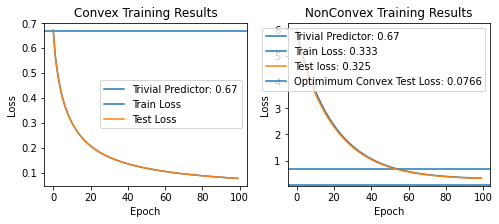



 MAKING BOT FOR AAPL with k =  10 ================================================== 

Training the Convex Model...


Loss = 0.051: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Training the NonConvex Model...


0.2031: 100%|██████████| 100/100 [13:15<00:00,  7.96s/it]


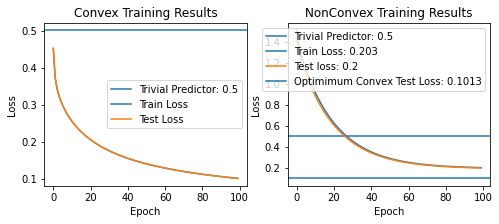



 MAKING BOT FOR AAPL with k =  82 ================================================== 

Training the Convex Model...


Loss = 0.028: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Training the NonConvex Model...


0.2356: 100%|██████████| 100/100 [13:20<00:00,  8.00s/it]


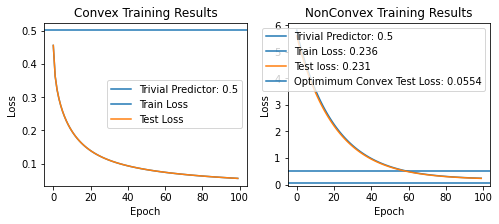



 MAKING BOT FOR IBM with k =  10 ================================================== 

Training the Convex Model...


Loss = 0.039: 100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Training the NonConvex Model...


0.2119: 100%|██████████| 100/100 [13:20<00:00,  8.01s/it]


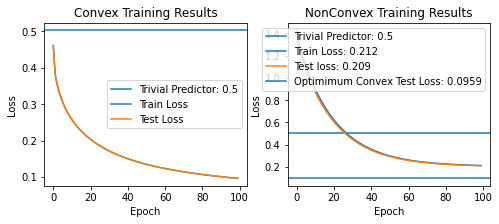



 MAKING BOT FOR IBM with k =  82 ================================================== 

Training the Convex Model...


Loss = 0.028: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Training the NonConvex Model...


0.2356: 100%|██████████| 100/100 [13:38<00:00,  8.19s/it]


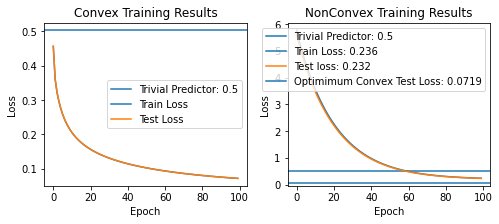

In [ ]:
### Train with last 75%, and run on next 25%
n_epochs = 100

for tick in ["MSFT", "AAPL", "IBM"]:
  for k in [10, 82]:

    print("\n\n MAKING BOT FOR", tick, "with k = ", k, "================================================== \n")
    data_df = cleaned_dfs[tick]
    bot = StockBot("Proper")

    split_ix = 240
    train_data = data_df.iloc[:split_ix, :]
    test_data = data_df.iloc[split_ix:, :]

    bot.train(train_data, SVD_k=k, n_epochs=n_epochs)
    np.save("/content/drive/My Drive/ECE271B/Project/Bots/" + tick + "_k" + str(k) + "_e" + str(n_epochs) + "_bot.npy", bot, allow_pickle=True)

In [25]:
### Train with last 75%, and run on next 25%
n_epochs = 100
split_ix = 230

roi = np.zeros((3, 5))
for ti, tick in enumerate(["MSFT", "AAPL", "IBM"]):
  data_df = cleaned_dfs[tick]
  roi[ti, 4] = data_df["close_price"][len(data_df["close_price"]) - 1] / data_df["open_price"][split_ix] - 1

  for ki, k in enumerate([10, 82]):

    bot = np.load("/content/drive/My Drive/ECE271B/Project/Bots/" + tick + "_k" + str(k) + "_e" + str(n_epochs) + "_bot.npy", allow_pickle=True).item()
    
    for ci, cvxty in enumerate(["Convex", "NonConvex"]):
      roi[ti, ki + 2*ci] = (bot.run(data_df.iloc[(split_ix):, :], cvxty, init_value=5000) / 5000) - 1

 Return of -0.004357714843750027 %
 Return of -0.035608203125000015 %
 Return of -0.037308984374999965 %
 Return of -0.03827958984375002 %
 Return of 0.02415146484374997 %
 Return of 0.005531933593750038 %
 Return of -0.005399511718749972 %
 Return of 0.0016689453125000586 %
 Return of -0.020332617187500013 %
 Return of 0.0017955078125000412 %
 Return of 0.02618769531249998 %
 Return of 0.0219581054687501 %


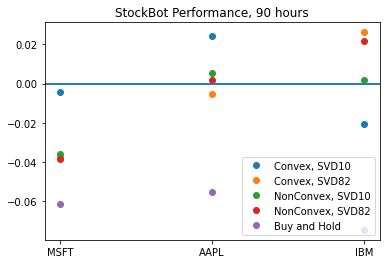

In [28]:
plt.plot(np.arange(3), roi, 'o');
plt.plot()
plt.xticks(np.arange(3), ["MSFT", "AAPL", "IBM"]);
plt.legend(["Convex, SVD10", "Convex, SVD82", "NonConvex, SVD10", "NonConvex, SVD82", "Buy and Hold"]);
plt.axhline(0.);
plt.axhline()
plt.title("StockBot Performance, 90 hours");